# Evaluation in-silico supervised submissions for protein engineering tournament

*   Take as input submission files
*   Compute the performance of each team for each property in each event
*   Merge them all into a summary CSV


## Preamble

In [18]:
%reload_ext jupyter_black

In [19]:
import pandas as pd
from pathlib import Path
import plotnine as p9

## Analysis

Let's create table with the source data

In [20]:
datasets = []
for f in Path("input").glob("*/test (with values).csv"):
    dd = pd.read_csv(f)
    dd = dd[
        [
            c
            for c in dd.columns
            if c
            not in {
                "Design id",
                "Design",
                "mutant",
                "mutation",
                "dataset",
                "Mutation",
                "Name",
            }
        ]
    ]
    if "DNA" in dd.columns and "AA" in dd.columns:
        dd = dd.drop(columns=["AA"]).rename(columns={"DNA": "mutated_sequence"})
    datasets.append(
        dd.melt(
            id_vars=["mutated_sequence"], var_name="target", value_name="truth"
        ).assign(
            dataset=f.parent.name.removesuffix(" (In Silico_ Supervised)").removesuffix(
                " "
            ),
        )
    )

In [21]:
truth = (
    pd.concat(datasets)
    .dropna()
    .groupby(["mutated_sequence", "target", "dataset"])
    .mean()
    .reset_index()
)
truth.to_csv("output/truth.csv.gz")

Let's create a table with predictions. Create a map of expected columns to ensure we find them back in the submission files.

In [22]:
dataset_to_target = (
    truth.groupby("dataset")
    .apply(lambda d: set(d.target.unique()), include_groups=False)
    .to_dict()
)

In [23]:
dataset_to_target

{'Alkaline phosphatase PafA': {'Carboxy 4-methylumbelliferyl phosphate ester (cMUP)',
  'methyl phosphate (MeP)',
  'methyl phosphodiester (MecMUP)'},
 'Alpha-Amylase': {'expression', 'specific activity', 'thermostability'},
 'Imine reductase': {'FIOP(fold improvement over positive control)'},
 'beta-glucosidase B': {'activity', 'melting point'}}

Note that the iminie reductase is unique on DNA and that some teams made different predictions for different DNA sequences.

In [24]:
datasets = []
for f in Path("input").glob("*/predictions/*.csv"):
    dd = pd.read_csv(f)
    dataset = f.parent.parent.name.removesuffix(
        " (In Silico_ Supervised)"
    ).removesuffix(" ")
    dd = dd[
        [
            c
            for c in dd.columns
            if c
            not in {
                "Expression_continuous_score",
                "mutant",
                "Unnamed: 0",
                "dataset",
                "mutation",
                "expression_skip",
            }
        ]
    ]
    if "DNA" in dd.columns and "AA" in dd.columns:
        dd = dd.drop(columns=["AA"]).rename(columns={"DNA": "mutated_sequence"})
    assert set(dd.columns) == dataset_to_target[dataset] | {
        "mutated_sequence"
    }, f"mismatch columns: {f.name} -- {dataset} -- {set(dd.columns)} -- {dataset_to_target[dataset]}"
    datasets.append(
        dd.melt(
            id_vars=["mutated_sequence"], var_name="target", value_name="prediction"
        ).assign(team=f.name.removesuffix(".csv"), dataset=dataset)
    )
subm = pd.concat(datasets).dropna().drop_duplicates()

In [25]:
comb = subm.merge(
    truth, on=["mutated_sequence", "target", "dataset"], how="left", validate="m:1"
)

In [26]:
comb.to_csv("output/truth-and-predictions.csv.gz")

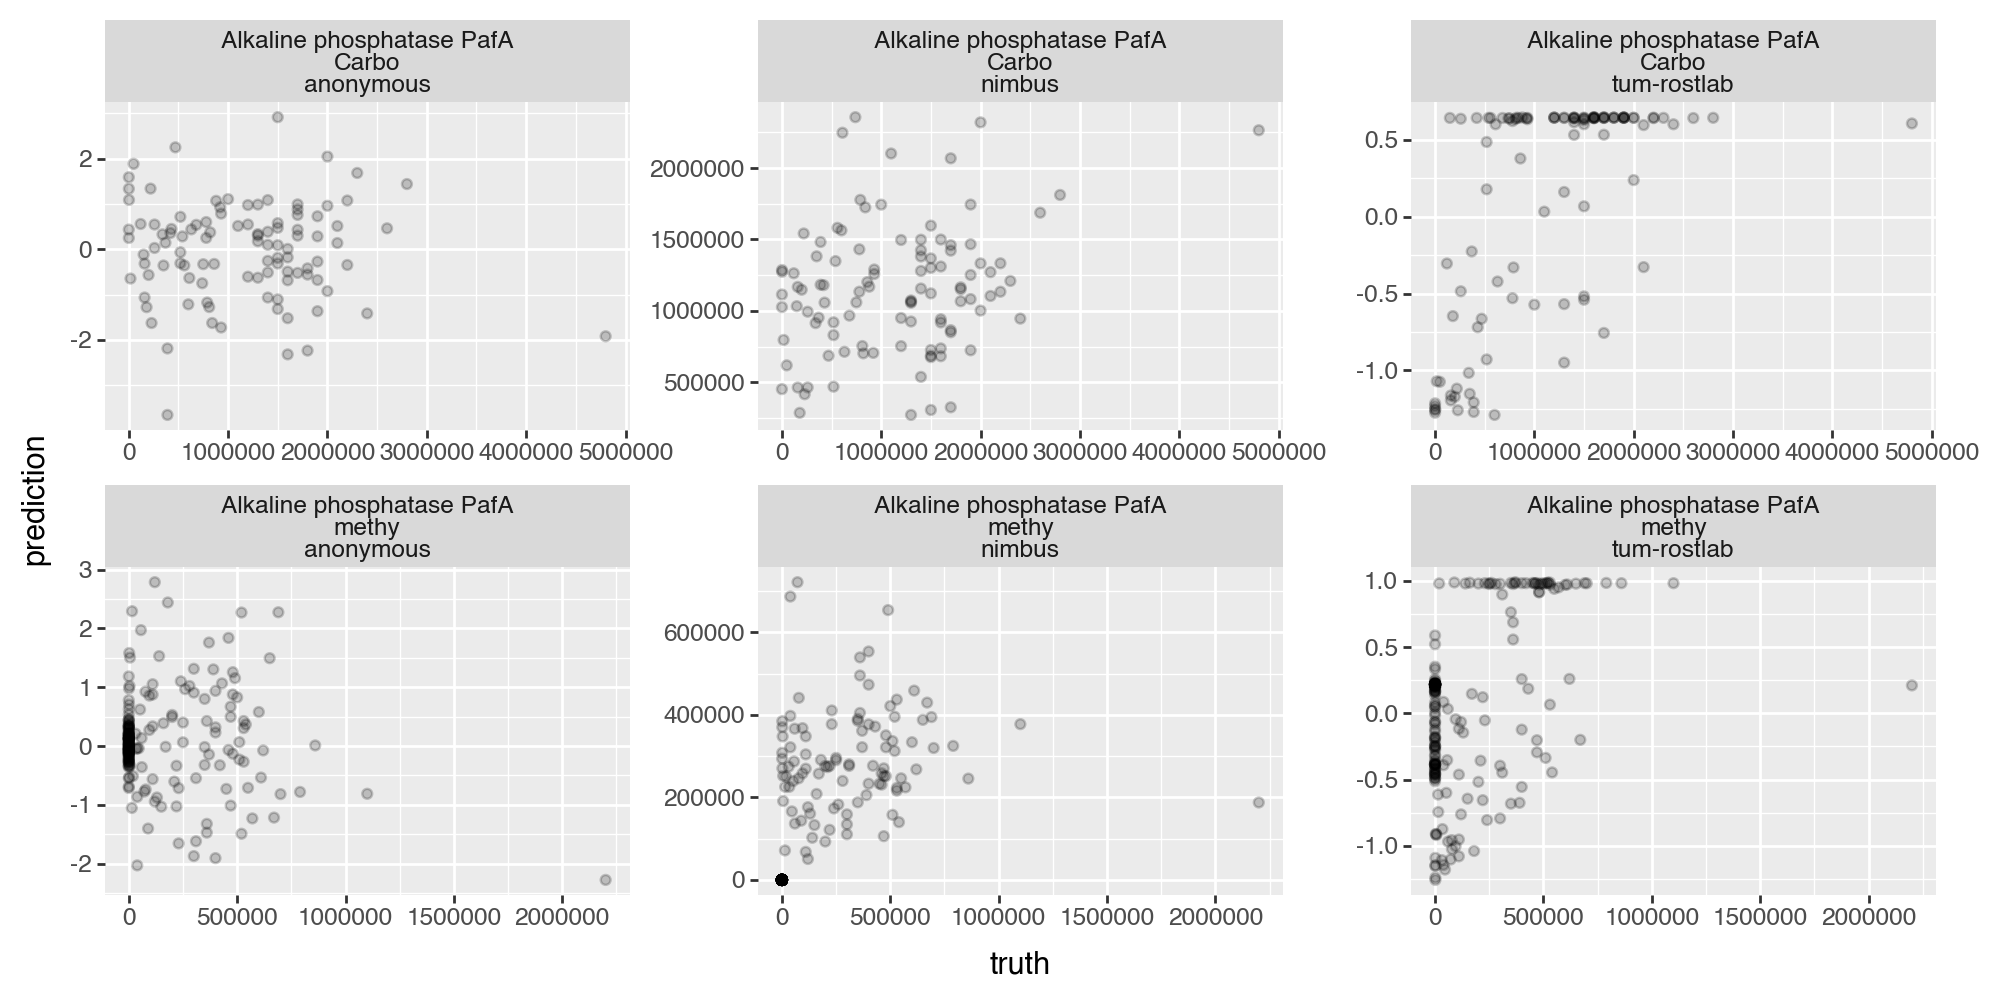

In [27]:
p9.options.set_option("figure_size", (10, 5))
(
    p9.ggplot(
        comb.assign(target=lambda d: d.target.str.slice(0, 5)).query(
            "dataset == 'Alkaline phosphatase PafA'"
        ),
        p9.aes("truth", "prediction"),
    )
    + p9.geom_point(alpha=0.2)
    + p9.facet_wrap("~ dataset + target + team", scales="free")
)

/Users/henning/.virtualenvs/pet-pilot/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 735 rows containing missing values.


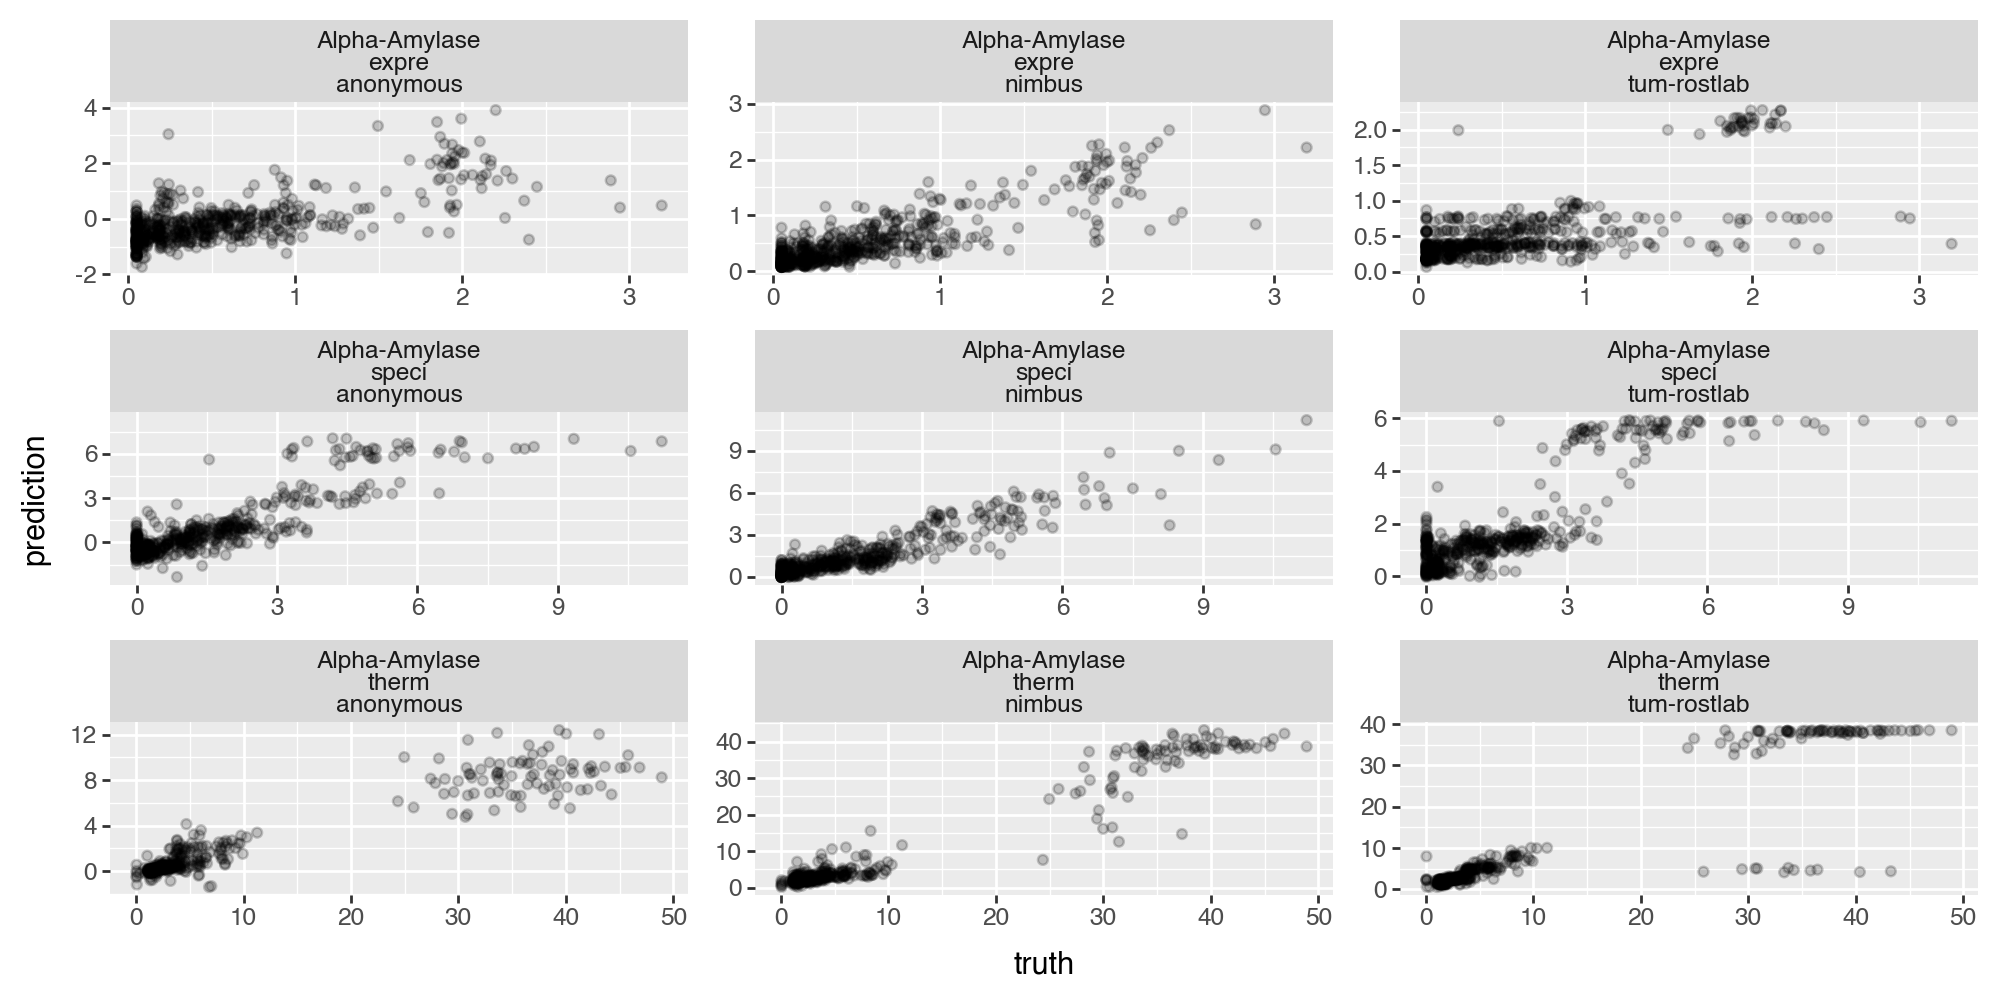

In [28]:
p9.options.set_option("figure_size", (10, 5))
(
    p9.ggplot(
        comb.assign(target=lambda d: d.target.str.slice(0, 5)).query(
            "dataset == 'Alpha-Amylase'"
        ),
        p9.aes("truth", "prediction"),
    )
    + p9.geom_point(alpha=0.2)
    + p9.facet_wrap("~ dataset + target + team", scales="free")
)

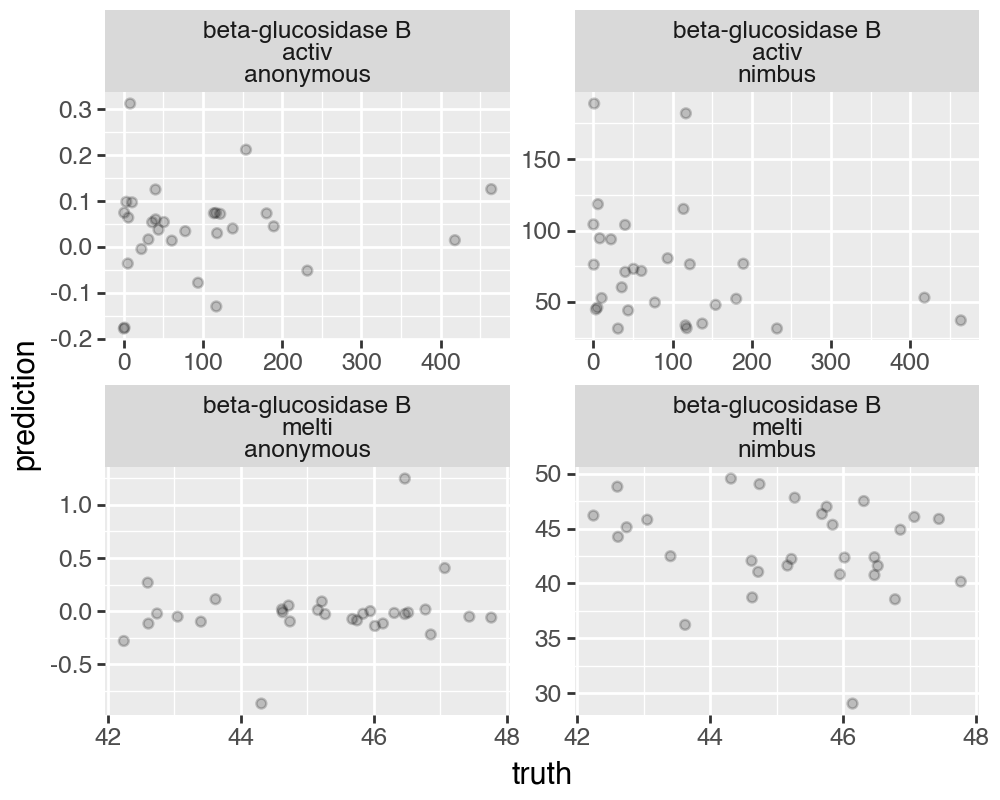

In [29]:
p9.options.set_option("figure_size", (5, 4))
(
    p9.ggplot(
        comb.assign(target=lambda d: d.target.str.slice(0, 5)).query(
            "dataset == 'beta-glucosidase B'"
        ),
        p9.aes("truth", "prediction"),
    )
    + p9.geom_point(alpha=0.2)
    + p9.facet_wrap("~ dataset + target + team", scales="free")
)

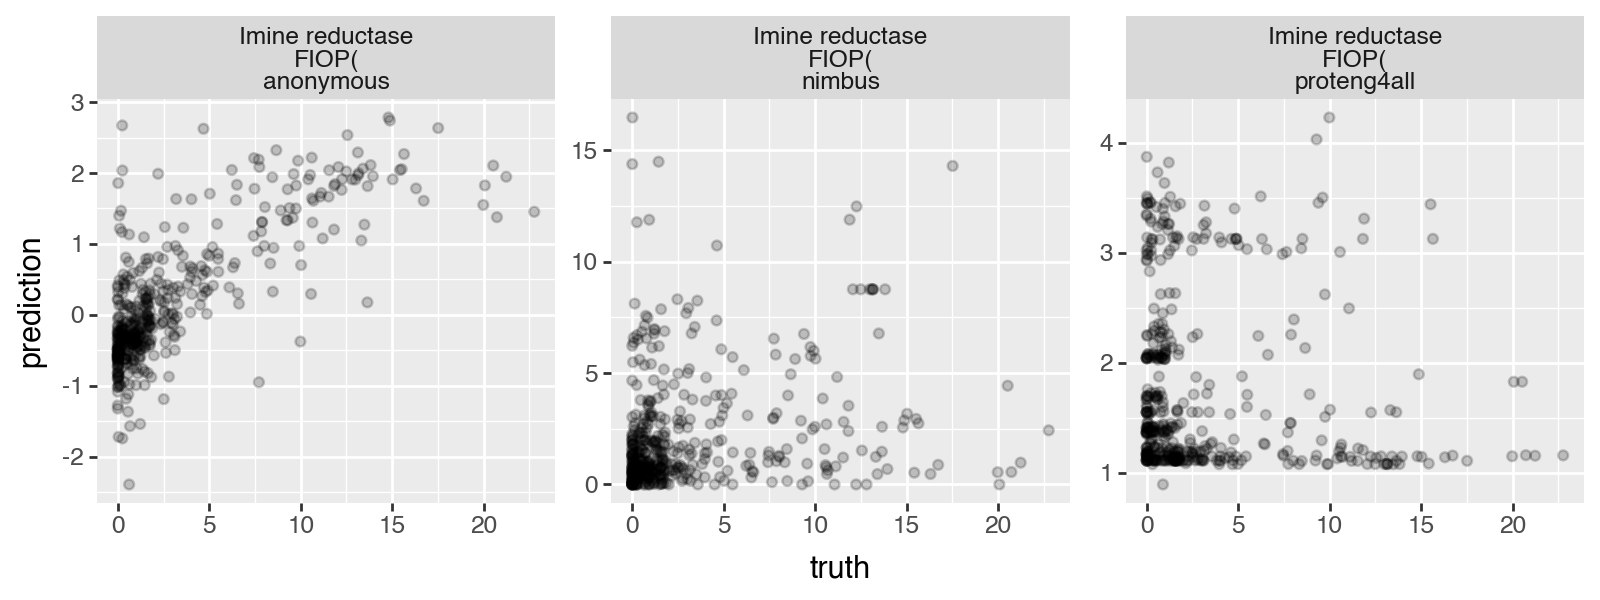

In [30]:
p9.options.set_option("figure_size", (8, 3))
(
    p9.ggplot(
        comb.assign(target=lambda d: d.target.str.slice(0, 5)).query(
            "dataset == 'Imine reductase'"
        ),
        p9.aes("truth", "prediction"),
    )
    + p9.geom_point(alpha=0.2)
    + p9.facet_wrap("~ dataset + target + team", scales="free")
)

In [31]:
spearman = (
    comb.drop(columns=["mutated_sequence"])
    .groupby(["dataset", "target", "team"])
    .corr(method="spearman")
    .loc[(slice(None), slice(None), slice(None), "truth"), ["prediction"]]
    .reset_index(level=3, drop=True)
)

In [32]:
spearman.unstack()

prediction  \
team                                                                          anonymous   
dataset                   target                                                          
Alkaline phosphatase PafA Carboxy 4-methylumbelliferyl phosphate ester (c...  -0.032933   
                          methyl phosphate (MeP)                              -0.086322   
                          methyl phosphodiester (MecMUP)                       0.086408   
Alpha-Amylase             expression                                           0.574071   
                          specific activity                                    0.772715   
                          thermostability                                      0.871589   
Imine reductase           FIOP(fold improvement over positive control)         0.696936   
beta-glucosidase B        activity                                             0.062069   
                          melting point                                        0.094338   

                                                                                        \
team                                                                            nimbus   
dataset                   target                                                         
Alkaline phosphatase PafA Carboxy 4-methylumbelliferyl phosphate ester (c...  0.210262   
                          methyl phosphate (MeP)                              0.150493   
                          methyl phosphodiester (MecMUP)                     -0.019987   
Alpha-Amylase             expression                                          0.766548   
                          specific activity                                   0.872199   
                          thermostability                                     0.828839   
Imine reductase           FIOP(fold improvement over positive control)        0.261838   
beta-glucosidase B        activity                                           -0.357953   
                          melting point                                      -0.241406   

                                                                                          \
team                                                                         proteng4all   
dataset                   target                                                           
Alkaline phosphatase PafA Carboxy 4-methylumbelliferyl phosphate ester (c...         NaN   
                          methyl phosphate (MeP)                                     NaN   
                          methyl phosphodiester (MecMUP)                             NaN   
Alpha-Amylase             expression                                                 NaN   
                          specific activity                                          NaN   
                          thermostability                                            NaN   
Imine reductase           FIOP(fold improvement over positive control)         -0.174469   
beta-glucosidase B        activity                                                   NaN   
                          melting point                                              NaN   

                                                                                          
team                                                                         tum-rostlab  
dataset                   target                                                          
Alkaline phosphatase PafA Carboxy 4-methylumbelliferyl phosphate ester (c...    0.618300  
                          methyl phosphate (MeP)                                0.632164  
                          methyl phosphodiester (MecMUP)                        0.588942  
Alpha-Amylase             expression                                            0.577709  
                          specific activity                                     0.730768  
                          thermostability                             

Averages

In [33]:
r1 = (
    spearman.reset_index()
    .drop(columns=["target"])
    .groupby(["dataset", "team"])
    .mean()
    .rename(columns={"prediction": "Average Spearman"})
)
r1

Average Spearman
dataset                   team                         
Alkaline phosphatase PafA anonymous           -0.010949
                          nimbus               0.113589
                          tum-rostlab          0.613136
Alpha-Amylase             anonymous            0.739458
                          nimbus               0.822529
                          tum-rostlab          0.738297
Imine reductase           anonymous            0.696936
                          nimbus               0.261838
                          proteng4all         -0.174469
beta-glucosidase B        anonymous            0.078203
                          nimbus              -0.299680

In [34]:
r1.to_csv("../doc/supervised-board.csv")